# NLP - Multi-Emotion Detection in Tweets

According to Plutchik’s Wheel of Emotions (Plutchik and Kellerman, 1986), emotions are based on four basic emotional axes, these opposite emotion pairs are: joy x sadness, anger x fear, trust x disgust and surprise x anticipation. In this notebook, we are going to explore the [Brazilian Stock Market Tweets with Emotions
](https://www.kaggle.com/datasets/fernandojvdasilva/stock-tweets-ptbr-emotions) dataset to identify these emotions in Brazilian stock market tweets. To tackle this problem, we are going to explore Machine Learning techniques, and Natural Language Processing (NLP), such as TF-IDF, Word Embeddings, and BERT.   

**Statement**: Given a tweet (small text), we have to assign nine emotional labels to it.

> Plutchik R. and H. Kellerman (eds). 1986. Emotion: Theory, Research and Experience. New York: Acad. Press.   
> Content for intermediate level in Machine Learning and Data Science!

<a id='ToC'></a>
## Table of Contents

- [Data Exploration](#data)
- [Multilabel Classification](#class)
  - [TF-IDF + Decision Tree](#strategy1)
  - [TF-IDF + Decision Tree + Text Preprocessing](#strategy2)
- [Conclusion](#conclusion)


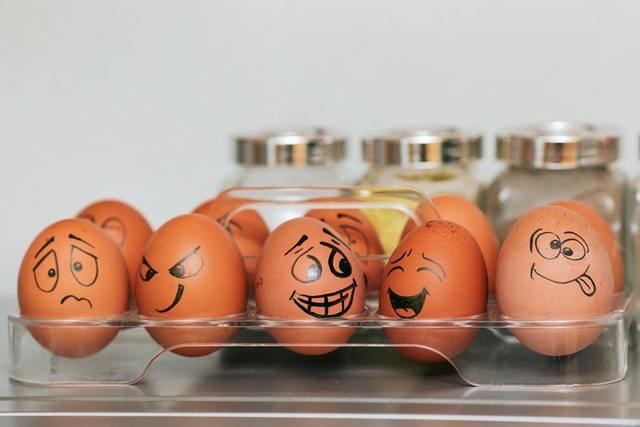

Photo by <a href="https://unsplash.com/@tengyart?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Tengyart</a> on <a href="https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

<a id="data"></a>

---
# Data Exploration


In this section, we are going to load the files into `pandas.DataFrame`. At last, elaborate our preprocessed datasets.

[Back to Table of Contents](#ToC)

In [1]:
%%capture
!pip install scikit-learn==1.0.2

# download the portuguese spacy module
!pip install spacy==2.3.7
!python -m spacy download pt_core_news_sm-2.3.0 --direct

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stock-tweets-ptbr-emotions/tweets_stocks-full_agreement.csv
/kaggle/input/stock-tweets-ptbr-emotions/tweets.csv
/kaggle/input/stock-tweets-ptbr-emotions/tweets_stocks.csv
/kaggle/input/stock-tweets-ptbr-emotions/tweets_annotators.csv
/kaggle/input/stock-tweets-ptbr-emotions/tweets_annotations.csv


In [4]:
train_set = pd.read_csv('/kaggle/input/stock-tweets-ptbr-emotions/tweets_stocks.csv')
test_set  = pd.read_csv('/kaggle/input/stock-tweets-ptbr-emotions/tweets_stocks-full_agreement.csv')

train_set

,tweet_id,text,TRU,DIS,JOY,SAD,ANT,SUR,ANG,FEA,NEUTRAL,conf_tru_dis,conf_joy_sad,conf_ant_sur,conf_ang_fea,num_annot
0,446333972562591745l,enquanto isso #lame4 rs,0,0,-1,-1,0,0,0,0,-1,0.667,0.667,0.667,0.667,3
1,446341582183464960l,"PETR4 subiu na bolsa 13,50. Muito bem, surpres...",1,0,1,0,0,1,0,0,0,0.667,1.000,0.667,1.000,3
2,443844230512144385l,$LREN3 - Lojas Renner (lren-nm) - Ago - 17/04/...,0,0,0,0,0,0,0,0,1,1.000,1.000,1.000,1.000,3
3,448105739962548224l,"vai, oibr4. um troux... ops... investidor prec...",0,1,0,1,0,0,1,0,0,0.667,0.667,0.667,0.667,3
4,446250331123773440l,$LREN3 - Lojas Renner (lren-nm) - Declaracao E...,0,0,0,0,-1,-1,-2,-2,-1,0.667,0.667,0.667,0.333,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,456788707576532992l,$EMBR3 - Embraer (embr-nm) - Aviso Aos Acionis...,0,0,0,0,1,0,0,0,0,0.667,0.667,0.667,0.667,3
4513,458688220092715008l,ABEV3: Oportunidade de compra (+ de 20% de alt...,1,0,0,0,1,0,0,0,0,0.667,0.667,0.667,0.667,3
4514,444219554114195457l,BBAS3_Mensal !!! Alguém tem algum recado para ...,0,1,-2,-2,-2,-2,0,0,-1,0.667,0.333,0.333,0.667,3
4515,451468663569141760l,"Bradesco PN (BBDC4), Gráfico Semanal. Estudo t...",0,0,0,0,0,0,0,0,1,0.667,1.000,1.000,1.000,3


## Clean train-set

Let's create the train set, excluding the test data and non-useful classes.

In [5]:
# remove test set from train set
mask_remove_test = np.logical_not(train_set['tweet_id'].isin(test_set['tweet_id']))
train_set = train_set[mask_remove_test]

train_set

,tweet_id,text,TRU,DIS,JOY,SAD,ANT,SUR,ANG,FEA,NEUTRAL,conf_tru_dis,conf_joy_sad,conf_ant_sur,conf_ang_fea,num_annot
0,446333972562591745l,enquanto isso #lame4 rs,0,0,-1,-1,0,0,0,0,-1,0.667,0.667,0.667,0.667,3
1,446341582183464960l,"PETR4 subiu na bolsa 13,50. Muito bem, surpres...",1,0,1,0,0,1,0,0,0,0.667,1.000,0.667,1.000,3
3,448105739962548224l,"vai, oibr4. um troux... ops... investidor prec...",0,1,0,1,0,0,1,0,0,0.667,0.667,0.667,0.667,3
4,446250331123773440l,$LREN3 - Lojas Renner (lren-nm) - Declaracao E...,0,0,0,0,-1,-1,-2,-2,-1,0.667,0.667,0.667,0.333,3
5,448130972039385089l,Barriga para dentro em uma semana - http://t.c...,-2,-2,-2,-2,-2,-2,0,0,-1,0.333,0.333,0.333,0.667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,456788707576532992l,$EMBR3 - Embraer (embr-nm) - Aviso Aos Acionis...,0,0,0,0,1,0,0,0,0,0.667,0.667,0.667,0.667,3
4513,458688220092715008l,ABEV3: Oportunidade de compra (+ de 20% de alt...,1,0,0,0,1,0,0,0,0,0.667,0.667,0.667,0.667,3
4514,444219554114195457l,BBAS3_Mensal !!! Alguém tem algum recado para ...,0,1,-2,-2,-2,-2,0,0,-1,0.667,0.333,0.333,0.667,3
4515,451468663569141760l,"Bradesco PN (BBDC4), Gráfico Semanal. Estudo t...",0,0,0,0,0,0,0,0,1,0.667,1.000,1.000,1.000,3


In [6]:
# is there some test data in train set?
train_set[train_set['tweet_id'].isin(test_set['tweet_id'])]

,tweet_id,text,TRU,DIS,JOY,SAD,ANT,SUR,ANG,FEA,NEUTRAL,conf_tru_dis,conf_joy_sad,conf_ant_sur,conf_ang_fea,num_annot


Let's transform the cases without class in `NEUTRAL`.

In [7]:
# columns of interest
X_column = 'text'
Y_columns = ['TRU','DIS','JOY','SAD','ANT','SUR','ANG','FEA','NEUTRAL']

In [8]:
# ignore cases without class
dd = train_set.query('NEUTRAL == -1')
for idx, row in dd.iterrows():
    for column in Y_columns:
        train_set.at[idx, column] = 0
    train_set.at[idx, 'NEUTRAL'] = 1

train_set

,tweet_id,text,TRU,DIS,JOY,SAD,ANT,SUR,ANG,FEA,NEUTRAL,conf_tru_dis,conf_joy_sad,conf_ant_sur,conf_ang_fea,num_annot
0,446333972562591745l,enquanto isso #lame4 rs,0,0,0,0,0,0,0,0,1,0.667,0.667,0.667,0.667,3
1,446341582183464960l,"PETR4 subiu na bolsa 13,50. Muito bem, surpres...",1,0,1,0,0,1,0,0,0,0.667,1.000,0.667,1.000,3
3,448105739962548224l,"vai, oibr4. um troux... ops... investidor prec...",0,1,0,1,0,0,1,0,0,0.667,0.667,0.667,0.667,3
4,446250331123773440l,$LREN3 - Lojas Renner (lren-nm) - Declaracao E...,0,0,0,0,0,0,0,0,1,0.667,0.667,0.667,0.333,3
5,448130972039385089l,Barriga para dentro em uma semana - http://t.c...,0,0,0,0,0,0,0,0,1,0.333,0.333,0.333,0.667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,456788707576532992l,$EMBR3 - Embraer (embr-nm) - Aviso Aos Acionis...,0,0,0,0,1,0,0,0,0,0.667,0.667,0.667,0.667,3
4513,458688220092715008l,ABEV3: Oportunidade de compra (+ de 20% de alt...,1,0,0,0,1,0,0,0,0,0.667,0.667,0.667,0.667,3
4514,444219554114195457l,BBAS3_Mensal !!! Alguém tem algum recado para ...,0,0,0,0,0,0,0,0,1,0.667,0.333,0.333,0.667,3
4515,451468663569141760l,"Bradesco PN (BBDC4), Gráfico Semanal. Estudo t...",0,0,0,0,0,0,0,0,1,0.667,1.000,1.000,1.000,3


In [9]:
# is there some train data without class?
train_set.query('NEUTRAL == -1')

,tweet_id,text,TRU,DIS,JOY,SAD,ANT,SUR,ANG,FEA,NEUTRAL,conf_tru_dis,conf_joy_sad,conf_ant_sur,conf_ang_fea,num_annot


<a href='#ToC'><span class="label label-info" style="font-size: 125%">Back to Table of Contents</span></a>

<a id="class"></a>

---
# Multilabel Classification

Multilabel classification is a classification task where each sample is labeled with `m` labels from `n_classes` possible classes, where `m` can be `0` to `n_classes` inclusive. [sklearn - Multilabel classification](https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification)

[Back to Table of Contents](#ToC)

<a id="strategy1"></a>

# Strategy 1 - TF-IDF

- First, we are going to create a simple text preprocessor
- Next, we are going to use the TF-IDF to extract features from the preprocessed texts
- At last, we are going to use Decision Tree algorithm to predict the classes

[Back to Table of Contents](#ToC)

In [10]:
import re
import string
import pt_core_news_sm
from unidecode import unidecode
from sklearn.base import TransformerMixin, BaseEstimator

nlp = pt_core_news_sm.load()

In [11]:
class SimpleTextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Text preprocessing includes steps:
        - Lower case
        - Remove accents
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        data = pd.Series(X) if not isinstance(X, pd.Series) else X
        data = data.apply(self._preprocess_text)
        return data

    def _preprocess_text(self, text):
        # handed functions
        pre_text = text.lower()
        pre_text = unidecode(pre_text)
        return pre_text

In [12]:
# just a test to see the preprocessing
tp = SimpleTextPreprocessor()
tp.transform(train_set['text'].iloc[0:4])

0                              enquanto isso #lame4 rs
1    petr4 subiu na bolsa 13,50. muito bem, surpres...
3    vai, oibr4. um troux... ops... investidor prec...
4    $lren3 - lojas renner (lren-nm) - declaracao e...
Name: text, dtype: object

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe1 = Pipeline(steps=[
    ('normalize', SimpleTextPreprocessor()), 
    ('features', TfidfVectorizer(
        ngram_range=(1, 2), analyzer='word',
        sublinear_tf=True, max_features=3_000,
        max_df=0.9, preprocessor=None
    )),
    ('classifier', DecisionTreeClassifier(random_state=1))
])

In [14]:
%%time
pipe1.fit(train_set[X_column], train_set[Y_columns])

CPU times: user 5.1 s, sys: 7.11 ms, total: 5.1 s
Wall time: 5.12 s


Pipeline(steps=[('normalize', SimpleTextPreprocessor()),
                ('features',
                 TfidfVectorizer(max_df=0.9, max_features=3000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('classifier', DecisionTreeClassifier(random_state=1))])

### Evaluation

Let's evaluate the classes performance using `classification_report`. The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise and would be the same for all metrics. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=12):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap="crest")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted')
    axes.set_title(class_label)

def run_confusion_matrix(Y_test, Y_pred, labels, size=(3,3)):
    vis_arr = multilabel_confusion_matrix(Y_test, Y_pred)
    fig, ax = plt.subplots(size[0], size[1], figsize=(12, 7))
    for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
    fig.tight_layout()
    plt.show()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [18]:
# predict the classes
Y_test = test_set[Y_columns]
Y_pred = pipe1.predict(test_set[X_column])

print(classification_report(Y_test, Y_pred, target_names=Y_columns))
print('accuracy', f'{accuracy_score(Y_test, Y_pred):.4f}')

              precision    recall  f1-score   support

         TRU       0.32      0.23      0.27        52
         DIS       0.29      0.33      0.31        15
         JOY       0.33      0.23      0.27        31
         SAD       0.15      0.15      0.15        13
         ANT       0.30      0.21      0.24        39
         SUR       0.07      0.04      0.05        23
         ANG       0.57      0.40      0.47        10
         FEA       0.00      0.00      0.00         5
     NEUTRAL       0.79      0.83      0.81       249

   micro avg       0.60      0.56      0.58       437
   macro avg       0.31      0.27      0.29       437
weighted avg       0.57      0.56      0.56       437
 samples avg       0.68      0.67      0.67       437

accuracy 0.6377


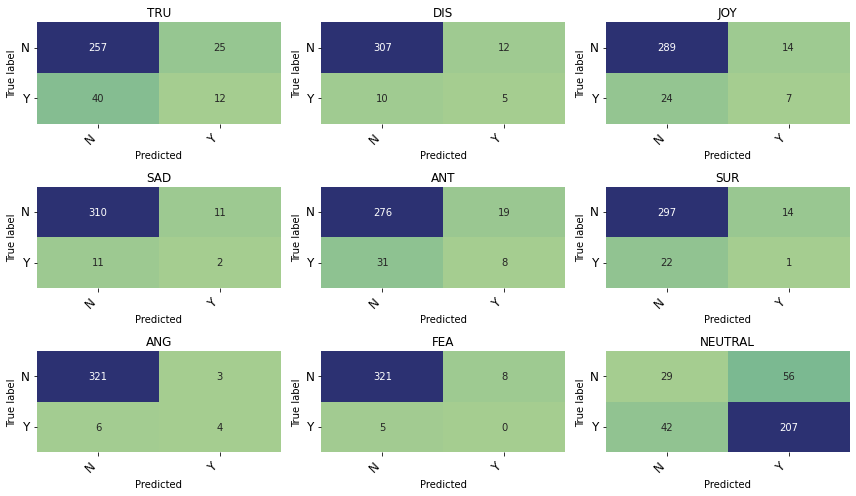

In [19]:
run_confusion_matrix(Y_test, Y_pred, labels=Y_columns)

<a id="strategy2"></a>

## Strategy 2 - TF-IDF + Robust Preprocessing

Now, we are going to execute a serie of preprocessing techniques to enrich our data.

[Back to Table of Contents](#ToC)

In [20]:
class RobustTextPreprocessor(SimpleTextPreprocessor):
    """
    Text preprocessing includes steps:
        - Lower case
        - Remove accents
        - Replace @citations
        - Replace http://websites.com
        - Remove numbers
        - Remove special characters symbols
        - Remove breakline
        - Lemming
    """
    def __init__(self, nlp=nlp):
        self.nlp = nlp

    def _preprocess_text(self, text):
        # handed functions
        pre_text = super()._preprocess_text(text)
        pre_text = self._replace_citation(pre_text)
        pre_text = self._replace_website(pre_text)
        pre_text = self._remove_number(pre_text)
        pre_text = self._remove_punct(pre_text)
        pre_text = self._remove_breakline(pre_text)
        pre_text = self._remove_extra_spaces(pre_text)
        pre_text = self._lemmatize(pre_text)
        return pre_text

    def _remove_number(self, text):
        # Remove numbers
        return re.sub(r'\d', ' ', text)

    def _replace_citation(self, text):
        # Replace @\w by CITATION
        return re.sub(r'@[\w\d]+', 'CITATION',  text)

    def _replace_website(self, text):
        # Replace http://websites.com by SITE
        return re.sub(r'https?:\/\/.+', 'SITE',  text)

    def _remove_punct(self, text):
        # Replace special characters symbols
        spaces = ' '*len(string.punctuation)
        return text.translate(str.maketrans(string.punctuation, spaces))

    def _remove_breakline(self, text):
        # Remove breakline
        return re.sub(r'\n', ' ',  text)
        
    def _remove_extra_spaces(self, text):
        # Remove extra spaces
        return re.sub(' +', ' ', text)

    def _lemmatize(self, text):
        # Normalization
        doc = self.nlp(text)
        return ' '.join(t.lemma_ for t in doc)

In [21]:
# just a test to see the preprocessing
tp = RobustTextPreprocessor()
tp.transform(train_set['text'].iloc[0:4])

0                                enquanto isso lame rs
1    petr subir o bolsar muito bem surpresar com o ...
3    ir oibr um troux ops investidor preciso pagar ...
4      lren loja renner lren nm declaracao e pagame...
Name: text, dtype: object

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe2 = Pipeline(steps=[
    ('normalize', RobustTextPreprocessor()), 
    ('features', TfidfVectorizer(
        ngram_range=(1, 2), analyzer='word',
        sublinear_tf=True, max_features=3_000,
        max_df=0.9, preprocessor=None
    )),
    ('classifier', DecisionTreeClassifier(random_state=1))
])

In [23]:
%%time
pipe2.fit(train_set[X_column], train_set[Y_columns])

CPU times: user 38 s, sys: 75.8 ms, total: 38.1 s
Wall time: 38.1 s


Pipeline(steps=[('normalize', RobustTextPreprocessor()),
                ('features',
                 TfidfVectorizer(max_df=0.9, max_features=3000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('classifier', DecisionTreeClassifier(random_state=1))])

### Evaluation

In [24]:
# predict the classes
Y_test = test_set[Y_columns].to_numpy()
Y_pred = pipe2.predict(test_set[X_column])

print(classification_report(Y_test, Y_pred, target_names=Y_columns))
print('accuracy', f'{accuracy_score(Y_test, Y_pred):.4f}')

              precision    recall  f1-score   support

         TRU       0.24      0.15      0.19        52
         DIS       0.07      0.07      0.07        15
         JOY       0.31      0.13      0.18        31
         SAD       0.12      0.08      0.10        13
         ANT       0.32      0.15      0.21        39
         SUR       0.20      0.09      0.12        23
         ANG       0.14      0.10      0.12        10
         FEA       0.00      0.00      0.00         5
     NEUTRAL       0.78      0.86      0.82       249

   micro avg       0.62      0.54      0.58       437
   macro avg       0.24      0.18      0.20       437
weighted avg       0.54      0.54      0.53       437
 samples avg       0.67      0.68      0.67       437

accuracy 0.6467


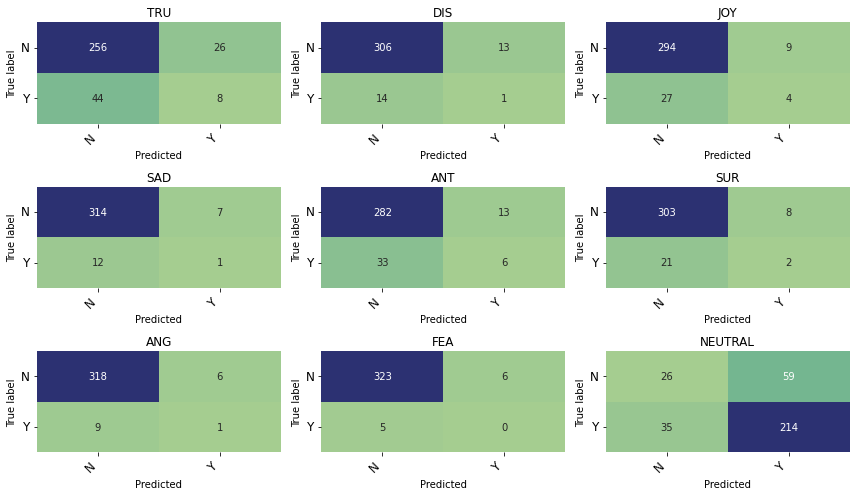

In [25]:
run_confusion_matrix(Y_test, Y_pred, labels=Y_columns)

<a href='#ToC'><span class="label label-info" style="font-size: 125%">Back to Table of Contents</span></a>

<a id="conclusion"></a>

---
# Conclusion

In general, both techniques presented similar results. In this case, the robust preprocessing approach was not able to help the classifier.

[Back to Table of Contents](#ToC)